# DACON 전력사용량 예측 AI 경진대회

- XGBoost

In [76]:
# 라이브러리 호출
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb

## 데이터 전처리
- building_info.csv
- train.csv
- test.csv


In [77]:
# train.csv 호출 및 불필요 데이터 삭제, column 명 변경
train = pd.read_csv('train_dataset/train.csv')
train.drop(['일시', '강수량(mm)', '일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)
train.columns = ['num_date_time', 'BNum', 'Temp', 'Wind', 'Humid', 'Elec']
train.dropna(inplace=True)

In [78]:
# test.csv 호출 및 불필요 데이터 삭제, column 명 변경
test = pd.read_csv('test/test.csv')
test.drop(['일시', '강수량(mm)'], axis=1, inplace=True)
test.columns = ['num_date_time', 'BNum', 'Temp', 'Wind', 'Humid']

In [79]:
# train.csv 시간만 분리
tmp = [int(time[-2:]) for time in train['num_date_time']]
train['Time'] = tmp

In [80]:
# train.csv 날짜 분리
tmp = [int(time[-5:-3]) for time in train['num_date_time']]
train['Date'] = tmp

In [81]:
# train.csv 월 분리
tmp = [int(time[-7:-5]) for time in train['num_date_time']]
train['Month'] = tmp

In [82]:
# test.csv 시간만 분리
tmp = [int(time[-2:]) for time in test['num_date_time']]
test['Time'] = tmp

In [83]:
# test.csv 날짜 분리
tmp = [int(time[-5:-3]) for time in test['num_date_time']]
test['Date'] = tmp

In [84]:
# test.csv 월 분리
tmp = [int(time[-7:-5]) for time in test['num_date_time']]
test['Month'] = tmp

In [85]:
# train.csv 불쾌지수 계산
train['DI'] = 9/5*train['Temp'] - 0.55*(1-train['Humid']/100)*(9/(5*train['Temp'])-26) + 32

In [86]:
# test.csv 불쾌지수 계산
test['DI'] = 9/5*test['Temp'] - 0.55*(1-test['Humid']/100)*(9/(5*test['Temp'])-26) + 32

In [87]:
# train.csv 체감온도 계산
train['FTemp'] = 13.12 + 0.6215*train['Temp'] - 11.37*(train['Wind']**0.16) + 0.3965*(train['Wind']**0.16)*train['Temp']

In [88]:
# test.csv 체감온도 계산
test['FTemp'] = 13.12 + 0.6215*test['Temp'] - 11.37*(test['Wind']**0.16) + 0.3965*(test['Wind']**0.16)*test['Temp']

In [89]:
# train.csv 정답 분리
X = train.drop(['num_date_time', 'Elec'], axis=1)
Y = train['Elec']

## feature 상관 관계 분석

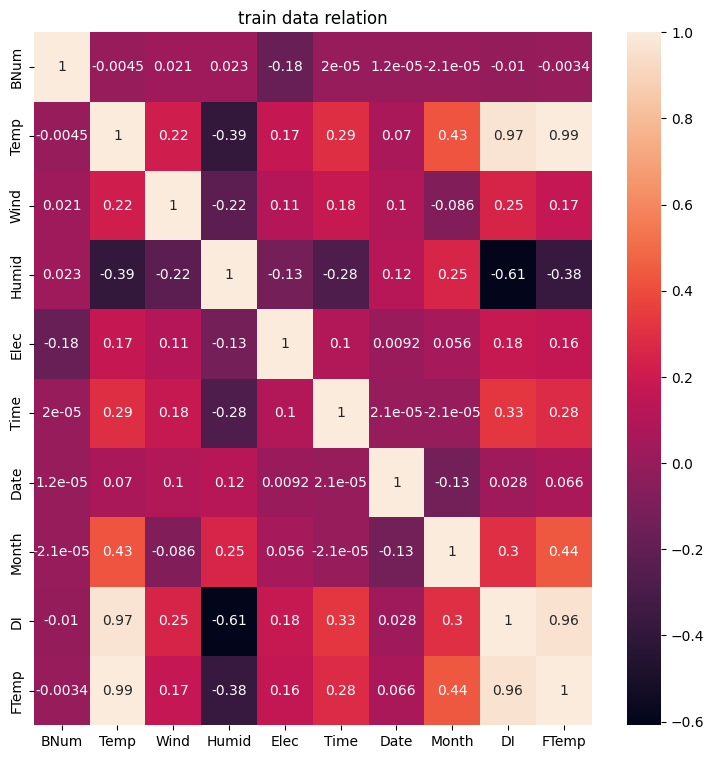

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(train.drop('num_date_time', axis=1).corr(), annot=True, ax=ax)

plt.title('train data relation')
plt.show()

## train, test 분리

In [91]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

In [92]:
train_x

,BNum,Temp,Wind,Humid,Time,Date,Month,DI,FTemp
66818,33,26.9,3.9,90.0,2,4,8,81.846320,28.962892
171410,85,19.2,1.0,84.0,2,3,6,68.839750,21.295600
46911,23,23.7,1.2,94.0,15,24,8,75.515494,25.818199
123660,61,26.7,1.6,74.0,12,23,7,83.768360,28.869412
47032,24,22.7,3.9,57.0,16,5,6,78.990247,24.282151
...,...,...,...,...,...,...,...,...,...
66022,33,26.2,2.0,84.0,22,1,7,81.441954,28.306459
176028,87,26.8,2.1,76.0,12,25,6,83.663134,28.938649
25752,13,23.9,1.9,93.0,0,24,7,76.018100,25.875392
46096,23,24.1,3.7,81.0,16,21,7,78.089195,25.861318


## 모델 학습
- GradientBoostingRegressor
- XGBoost

In [93]:
# 가중치 있는 mse 구현 https://saturncloud.io/blog/customizing-loss-functions-in-scikitlearn/ 참고
def MSE_W(alpha=1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [101]:
# 모델 정의
model = xgb.XGBRegressor(
    booster='gbtree',
    subsample=0.7,
    colsample_bytree=1,
    n_estimators=5000,
    eta = 0.01,
    max_depth=15,
    seed=42,
    gpu_id=0,
    reg_lambda=5,
    reg_alpha=5,
    gamma=1
)
model.set_params(**{'objective':MSE_W(3)})

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective=<function MSE_W.<locals>.weighted_mse_fixed at 0x7f7e7cd40d30>, ...)

In [102]:
model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)],
            early_stopping_rounds=300, verbose=False)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective=<function MSE_W.<locals>.weighted_mse_fixed at 0x7f7e7cd40d30>, ...)

## 모델 평가
- SMAPE

In [103]:
# 평가함수(해당 대회의 평가 방법)
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/((np.abs(true) + np.abs(pred))/2)) * 100

In [104]:
pred = model.predict(test_x)

In [105]:
SMAPE(test_y, pred)

5.455853047827515

## 결과 제출

In [106]:
ansXGB = pd.DataFrame()
ansXGB['num_date_time'] = test['num_date_time']
ansXGB['answer'] = model.predict(test.drop('num_date_time', axis=1))
ansXGB.to_csv('ansXGB.csv', index=False)


In [107]:
ansXGB

,num_date_time,answer
0,1_20220825 00,2151.958984
1,1_20220825 01,2137.761963
2,1_20220825 02,2042.770264
3,1_20220825 03,1738.710571
4,1_20220825 04,1717.306885
...,...,...
16795,100_20220831 19,911.387573
16796,100_20220831 20,821.088623
16797,100_20220831 21,691.278076
16798,100_20220831 22,620.949951
